# Introduction

In this notebook, we will learn how to average the results of a few models based on different criteria

## The full documentation can be accessed in this link: https://sedcreator.readthedocs.io/en/latest/index.html

---
---

As always we start off by importing the packages. Even though in this example we will only make use of `SedFitter` and `ModelPlotter`, we also import `SedFluxer`  for completeness

In [1]:
from sedcreator import SedFluxer, SedFitter, ModelPlotter
import numpy as np

To average the model, we first need to make the fitting to a set of fluxes. We will use what we learnt in [SedFitter_example-v0.9.7.ipynb](https://github.com/fedriani/sedcreator/blob/main/examples/SedFitter_example-v0.9.7.ipynb).

First we define the inputs needed to fit the SEDs.

In [2]:
#1)
AFGL2591_ALL_lambda = np.array([3.6,4.5,5.8,8.0,#Spitzer wavelengths
                                19.2,31.5,37.1,#SOFIA wavelengths
                                70.0,160.0,250.0,350.0,500.0])#Herschel wavelengths

AFGL2591_ALL_flux_bkg = np.array([74.45159540387745,173.42437308785574,342.88313518774004,308.6063570167687,#Spitzer fluxes
                                  681.7034925392351,2437.737318627827, 3196.318628553757,#SOFIA fluxes
                                  4445.462065581253,2172.1759140942445,535.9427155270951,151.5579727178684,25.49940584821297])#Herschel fluxes

AFGL2591_ALL_error = np.array([7.449173394643094,17.344681594266557,34.30506540367819,30.876043103828618,#Spitzer fluxes error
                               68.19855739627107,244.038808255289,320.6493605544995,#SOFIA fluxes error
                               449.73808374682807,326.85631175231276,135.5281164755594,52.60331099760318,19.737462585055212])#Herschel fluxes error


AFGL2591_ALL_upp_lim = np.array([1,1,1,1,#Spitzer fluxes are upper limits
                                 0,0,0,
                                 0,0,0,0,0],
                                dtype=bool)

AFGL2591_ALL_filters = np.array(['I1','I2','I3','I4',#Spitzer filter names
                                 'F8','L1','L4',#SOFIA filter names
                                 'P1','P3','P4','P5','P6'])#Herschel filter names

And initialise the SedFitter class

In [3]:
#2)
AFGL2591_fitter = SedFitter(extc_law='kmh',
                            lambda_array=AFGL2591_ALL_lambda,
                            flux_array=AFGL2591_ALL_flux_bkg,
                            err_flux_array=AFGL2591_ALL_error,
                            upper_limit_array=AFGL2591_ALL_upp_lim,
                            filter_array=AFGL2591_ALL_filters)

Now we call the function `sed_fit()` to fit our measurements.

In [4]:
#3)
AFGL2591_dist = 3300.0 #pc
AV_min = 0 #mag
AV_max = 1000 #mag

#4)

AFGL2591_sed_fit = AFGL2591_fitter.sed_fit(dist=AFGL2591_dist,AV_min=AV_min,AV_max=AV_max,
                                           method='minimize',progress=True)

100%|██████████████████████████████████████| 8640/8640 [00:30<00:00, 281.58it/s]


## Retrieving the SED results

In [5]:
AFGL2591_results_3p = AFGL2591_sed_fit.get_model_info(keys=['mcore','sigma','mstar'],
                                                      tablename=None)

AFGL2591_results_4p = AFGL2591_sed_fit.get_model_info(keys=['mcore','sigma','mstar','theta_view'],
                                                      tablename=None) 

The tables are ordered by chi square and are astropy tables. Let's see how one of them looks

## Obtaining the average of the fitted models

There are several options here.

1) One just gets the best model and retrieve the physical parameters.

However, in many ocassions the chi square values are very close to one another with somewhat different values for the physical properties.

2) One can decide to get the best 10 models

It is another choice, but this one is indendent from the chi square value.

3) One can get all models below a certain chi square value

Yet, another choice, with the caveat on where we set this cut

4) And one can discard 'unphysical' models

For example those models that predict the core radius larger than the aperture radius used when obtaining the flux.

In the SOMA survey, we make two cuts. One over chi square and another over the core radius. We do this to account for degenerancies in the SED fitting.

We first place a cut in the core radius to account for 'unphysical' models and take the models whose core radius are smaller than two times the aperture radius used to measure the fluxes.

1) Rcore < 2 x Rap

We then place a cut in chi square depending on the minimum chi square value.

1) If chi square min >= 1, we consider all models that satisfy chi square < 2xchi square min

2) If chi square min <1, we consider all models that satisfy chi square<=2

This is a choice we made based on different tests, but another one can well be placed.

## Example

For the sake of simplicity let's apply the chi square cut using the conditions above.

We need to first check what is the value of chi square min.

In [6]:
AFGL2591_results_4p['chisq'][0]

1.055645969303538

Since it is larger than 1, we will average the models taking two times the minimum chi square.

In [7]:
SedFitter().get_average_model(AFGL2591_results_4p,chisq_cut=2*AFGL2591_results_4p['chisq'][0])
#The first row is just the average of the first 5 models

method,number_of_models_used,mcore,Dmcore,sigma,Dsigma,mstar,Dmstar,theta_view,Dtheta_view,dist,av,Dav,rcore,Drcore,massenv,Dmassenv,theta_w_esc,Dtheta_w_esc,rstar,Drstar,lstar,Dlstar,tstar,Dtstar,mdisk,Dmdisk,rdisk,Drdisk,mdotd,Dmdotd,lbol,Dlbol,lbol_iso,Dlbol_iso,lbol_av,Dlbol_av,t_now,Dt_now
,,solMass,,g / cm2,,solMass,,deg,deg,pc,mag,mag,pc,,solMass,,deg,deg,solRad,,solLum,,K,,solMass,,AU,,solMass / yr,,solLum,,solLum,,solLum,,yr,
str22,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
average model method 1,5,430.26150,1.10502,0.31600,1.00000,37.63453,1.24867,19.85909,6.22155,3300.0,74.21632,16.22088,0.27153,1.05120,329.40752,1.22132,2.76808e+01,5.42814,8.32020,1.13339,2.12577e+05,1.56510,4.29896e+04,1.05062,12.54485,1.24867,2.12574e+02,1.22918,3.92059e-04,1.05474,2.64384e+05,1.47872,1.18730e+06,1.49127,1.92258e+05,1.02713,1.78941e+05,1.15398
average model method 2,74,312.65767,1.50814,0.69883,3.68861,50.74701,1.45597,37.64542,15.79509,3300.0,67.23563,41.95690,0.15565,2.33177,177.70102,1.62073,3.73719e+01,7.83406,11.05054,1.25283,4.51597e+05,1.82978,4.50348e+04,1.10542,16.91567,1.45597,1.97680e+02,2.06116,6.88846e-04,2.35067,5.58812e+05,1.77677,6.98131e+05,3.40583,1.67369e+05,1.16015,1.26799e+05,2.58710


Let's plot now this models color coded by chi square

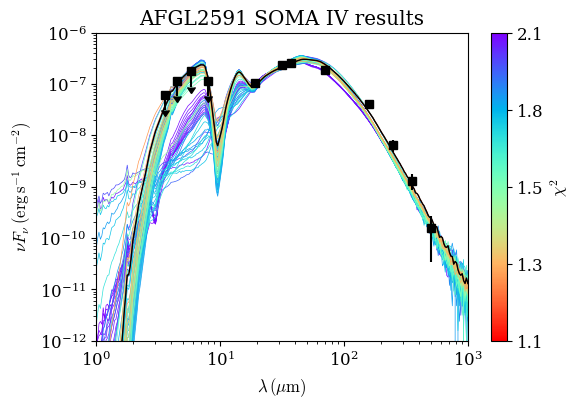

In [8]:
AFGL2591_md = ModelPlotter(AFGL2591_sed_fit)

AFGL2591_md.plot_multiple_seds(models=AFGL2591_results_4p[AFGL2591_results_4p['chisq']<2*AFGL2591_results_4p['chisq'][0]],
                               figsize=(6,4),
                               xlim=[1e0,1e3],ylim=[1e-12,1e-6],
                               title='AFGL2591 SOMA IV results',
                               marker='ks',cmap='rainbow_r',colorbar=True,
                               figname=None)

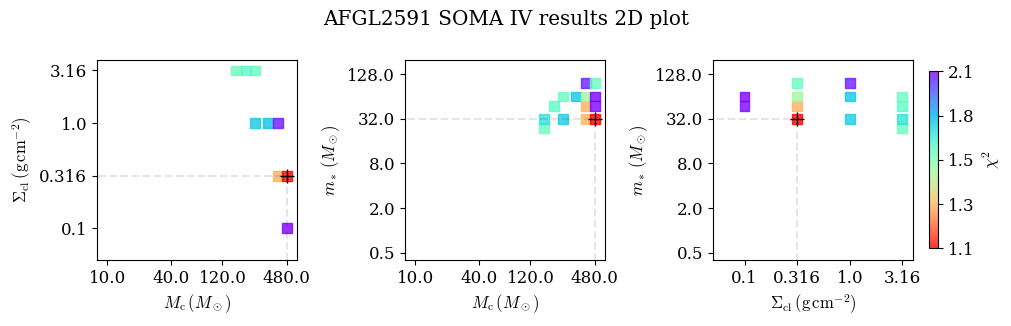

In [9]:
AFGL2591_md.plot2d(models=AFGL2591_results_4p[AFGL2591_results_4p['chisq']<2*AFGL2591_results_4p['chisq'][0]],
                   figsize=(10, 5),
                   marker='s',
                   markersize=50,
                   cmap='rainbow_r',
                   title='AFGL2591 SOMA IV results 2D plot',
                   figname=None)

---
---
<font size="4">Author: R. Fedriani (Instituto de Astrofisica de Andalucia and Chalmers University of Technology)

Last update: 14 June 2024</font>

---